<a href="https://colab.research.google.com/github/YanzhaoZ/PreBit/blob/main/price_base_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [82]:
%pip install yfinance
import yfinance as yf
import pandas as pd


Note: you may need to restart the kernel to use updated packages.


In [83]:
import torch
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import matplotlib.pyplot as plt
import time

from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import MinMaxScaler


# Loading the Price Data

In [84]:
start_date ='2023-07-12'
end_date = '2025-04-11'
#Earliest date: 2023-07-12 10:27:37+00:00
#Latest date: 2025-04-11 10:41:54+00:00
price = yf.download("NVDA", start=start_date, end=end_date)

#relative_price, will calculate the change in % compared to the day before. 
relative_price = (price/price.shift(1)-1)

[*********************100%***********************]  1 of 1 completed


In [85]:
price.head()

Price,Close,High,Low,Open,Volume
Ticker,NVDA,NVDA,NVDA,NVDA,NVDA
Date,,,,,
2023-07-12,43.878044,43.911027,42.753658,43.009519,481277000
2023-07-13,45.951912,46.129812,44.467722,44.493708,478204000
2023-07-14,45.444191,48.061761,45.035414,46.557582,772075000
2023-07-17,46.435650,46.470631,45.237307,46.263747,510488000
2023-07-18,47.468086,47.869867,45.709048,46.675520,569164000


In [86]:
relative_price.head()

Price,Close,High,Low,Open,Volume
Ticker,NVDA,NVDA,NVDA,NVDA,NVDA
Date,,,,,
2023-07-12,NaN,NaN,NaN,NaN,NaN
2023-07-13,0.047264,0.050529,0.040092,0.034508,-0.006385
2023-07-14,-0.011049,0.041881,0.012766,0.046386,0.614531
2023-07-17,0.021817,-0.033106,0.004483,-0.006311,-0.338810
2023-07-18,0.022234,0.030110,0.010428,0.008901,0.114941


In [87]:
#add in the label
#I can start with the % change of the daily closing price, then create labels.

price_2 = price[["Close"]].copy()  # Keeps it as a DataFrame

price['change']=price_2.apply(lambda x: x.shift(-1)/x -1)
price['change_label']=price['change'].apply (lambda x: x>0 )
#NaN > 0 gives false? Perhaps I could drop na before this step? 


#copy the label to relative_price part as well. 
relative_price['change'] = price['change']
relative_price['change_label']=price['change_label']

In [88]:
print (len(price),len(relative_price))

440 440


In [89]:
price = price.dropna()
relative_price = relative_price.dropna()

In [90]:
#price would lose the last day, because no information on next day price to create the label
#relative price, would ALSO lose the first day, because no information to calculate the relative changes .
print (len(price),len(relative_price))

439 438


In [91]:
relative_price[5:12]

Price,Close,High,Low,Open,Volume,change,change_label
Ticker,NVDA,NVDA,NVDA,NVDA,NVDA,,
Date,,,,,,,
2023-07-20,-0.033073,-0.015287,-0.035942,-0.020163,0.258158,-0.026604,False
2023-07-21,-0.026604,-0.025931,-0.021348,-0.015460,0.791842,0.006839,True
2023-07-24,0.006839,-0.016504,-0.001360,-0.023084,-0.603104,0.023917,True
2023-07-25,0.023917,0.023809,0.020050,0.004695,-0.090022,-0.004969,False
2023-07-26,-0.004969,-0.002815,-0.006522,0.024032,0.046414,0.009857,True
2023-07-27,0.009857,0.029140,0.025095,0.010821,0.251866,0.018518,True
2023-07-28,0.018518,-0.007765,0.013792,0.003203,-0.273659,-0.000449,False


In [92]:
relative_price['change_label'].value_counts()

change_label
True     239
False    199
Name: count, dtype: int64

# Adding in technical indicators

In [93]:
price.head()

Price,Close,High,Low,Open,Volume,change,change_label
Ticker,NVDA,NVDA,NVDA,NVDA,NVDA,,
Date,,,,,,,
2023-07-12,43.878044,43.911027,42.753658,43.009519,481277000,0.047264,True
2023-07-13,45.951912,46.129812,44.467722,44.493708,478204000,-0.011049,False
2023-07-14,45.444191,48.061761,45.035414,46.557582,772075000,0.021817,True
2023-07-17,46.435650,46.470631,45.237307,46.263747,510488000,0.022234,True
2023-07-18,47.468086,47.869867,45.709048,46.675520,569164000,-0.008780,False


In [94]:
def get_technical_indicators(dataset):
    # Create 7 and 21 days Moving Average
    dataset['ma7'] = dataset['Close'].rolling(window=7).mean()
    dataset['ma21'] = dataset['Close'].rolling(window=21).mean()
    
    # Create MACD
    #dataset['26ema'] = pd.ewma(dataset['Close'], span=26)
    dataset['26ema'] = dataset['Close'].ewm(span=26).mean()
    #dataset['12ema'] = pd.ewma(dataset['Close'], span=12)
    dataset['12ema'] = dataset['Close'].ewm(span=12).mean()
    dataset['MACD'] = (dataset['12ema']-dataset['26ema'])

    # Create Bollinger Bands
    #dataset['20sd'] = pd.stats.moments.rolling_std(dataset['Close'],20)
    dataset['20sd'] = dataset["Close"].rolling(window=20).std()
    dataset['upper_band'] = dataset['ma21'] + (dataset['20sd']*2)
    dataset['lower_band'] = dataset['ma21'] - (dataset['20sd']*2)
    
    # Create Exponential moving average
    dataset['ema'] = dataset['Close'].ewm(com=0.5).mean()
    
    # Create Momentum
    #dataset['momentum'] = dataset['Close']-1
    
    return dataset


In [95]:
test_df = pd.DataFrame({'B':[1,2,3,4,5,6,7]})

In [96]:
pd.__version__

'2.2.3'

In [97]:
price_processed = get_technical_indicators(price)
#price.head()

In [98]:
price_processed.tail()

Price,Close,High,Low,Open,Volume,change,change_label,ma7,ma21,26ema,12ema,MACD,20sd,upper_band,lower_band,ema
Ticker,NVDA,NVDA,NVDA,NVDA,NVDA,,,,,,,,,,,
Date,,,,,,,,,,,,,,,,
2025-04-03,101.800003,105.629997,101.599998,103.510002,338769400,-0.073576,False,109.372857,113.731887,115.851872,111.606592,-4.245280,5.405667,124.543221,102.920553,104.607241
2025-04-04,94.309998,100.129997,92.110001,98.910004,532273800,0.035309,True,106.594285,112.958086,114.256178,108.945578,-5.310600,6.959510,126.877106,99.039065,97.742412
2025-04-07,97.639999,101.750000,86.620003,87.459999,611041300,-0.013724,False,104.624285,112.241912,113.025350,107.206258,-5.819092,7.660413,127.562738,96.921087,97.674137
2025-04-08,96.300003,105.849998,94.459999,103.809998,476243400,0.187227,True,102.714286,111.733809,111.786435,105.528373,-6.258063,8.447113,128.628036,94.839583,96.758048
2025-04-09,114.330002,115.099998,97.529999,98.889999,612918300,-0.059127,False,103.564286,111.999524,111.974848,106.882469,-5.092378,8.419066,128.837656,95.161392,108.472684


In [99]:
price_processed = price_processed.dropna()
price_processed.isnull().value_counts()

(Close, NVDA)  (High, NVDA)  (Low, NVDA)  (Open, NVDA)  (Volume, NVDA)  (change, )  (change_label, )  (ma7, )  (ma21, )  (26ema, )  (12ema, )  (MACD, )  (20sd, )  (upper_band, )  (lower_band, )  (ema, )
False          False         False        False         False           False       False             False    False     False      False      False     False     False           False           False      419
Name: count, dtype: int64

In [100]:
price_processed.head()
#although I'm not very sure about how 26ema can be calculated when I don't have 26 days of data before this day ? 
#and ema, with this particular set up, seems a bit off? : https://stackoverflow.com/questions/37924377/does-pandas-calculate-ewm-wrong
#the link above provides an alternate view, but I think with the amount of days I have, it shouldn't really matter that much. 
#Let's keep going w/o it first. 

Price,Close,High,Low,Open,Volume,change,change_label,ma7,ma21,26ema,12ema,MACD,20sd,upper_band,lower_band,ema
Ticker,NVDA,NVDA,NVDA,NVDA,NVDA,,,,,,,,,,,
Date,,,,,,,,,,,,,,,,
2023-08-09,42.530781,44.287821,42.111008,44.249840,586449000,-0.003901,False,44.633635,45.400786,45.160389,44.836480,-0.323909,1.183600,47.767986,43.033587,43.290146
2023-08-10,42.364876,43.550230,41.812176,42.137000,492705000,-0.036166,False,44.045528,45.328731,44.906639,44.446346,-0.460294,1.365614,48.059959,42.597502,42.673299
2023-08-11,40.832706,41.995074,40.616825,41.728217,533085000,0.070934,True,43.558079,45.084959,44.542919,43.878217,-0.664702,1.690272,48.465504,41.704415,41.446237
2023-08-14,43.729122,43.776097,40.289003,40.463907,690286000,0.004274,True,43.449280,45.003289,44.471352,43.854856,-0.616496,1.683258,48.369806,41.636772,42.968161
2023-08-15,43.916023,45.243302,43.686149,44.535688,676512000,-0.010332,False,43.343624,44.883307,44.423183,43.864413,-0.558770,1.586142,48.055592,41.711022,43.600069


In [101]:
#visualise the chart
def plot_technical_indicators(dataset, last_days):
    plt.figure(figsize=(16, 10), dpi=100)
    shape_0 = dataset.shape[0]
    xmacd_ = shape_0-last_days
    
    dataset = dataset.iloc[-last_days:, :]
    x_ = range(3, dataset.shape[0])
    x_ =list(dataset.index)
    
    # Plot first subplot
    plt.subplot(2, 1, 1)
    plt.plot(dataset['ma7'],label='MA 7', color='g',linestyle='--')
    plt.plot(dataset['Close'],label='Closing Price', color='b')
    plt.plot(dataset['ma21'],label='MA 21', color='r',linestyle='--')
    plt.plot(dataset['upper_band'],label='Upper Band', color='c')
    plt.plot(dataset['lower_band'],label='Lower Band', color='c')
    plt.fill_between(x_, dataset['lower_band'], dataset['upper_band'], alpha=0.35)
    plt.title('Technical indicators for NVIDIA stock - last {} days.'.format(last_days))
    plt.ylabel('USD')
    plt.legend()

    # Plot second subplot
    plt.subplot(2, 1, 2)
    plt.title('MACD')
    plt.plot(dataset['MACD'],label='MACD', linestyle='-.')
    # plt.hlines(15, xmacd_, shape_0, colors='g', linestyles='--')
    # plt.hlines(-15, xmacd_, shape_0, colors='g', linestyles='--')
    #plt.plot(dataset['log_momentum'],label='Momentum', color='b',linestyle='-')

    plt.legend()
    plt.show()

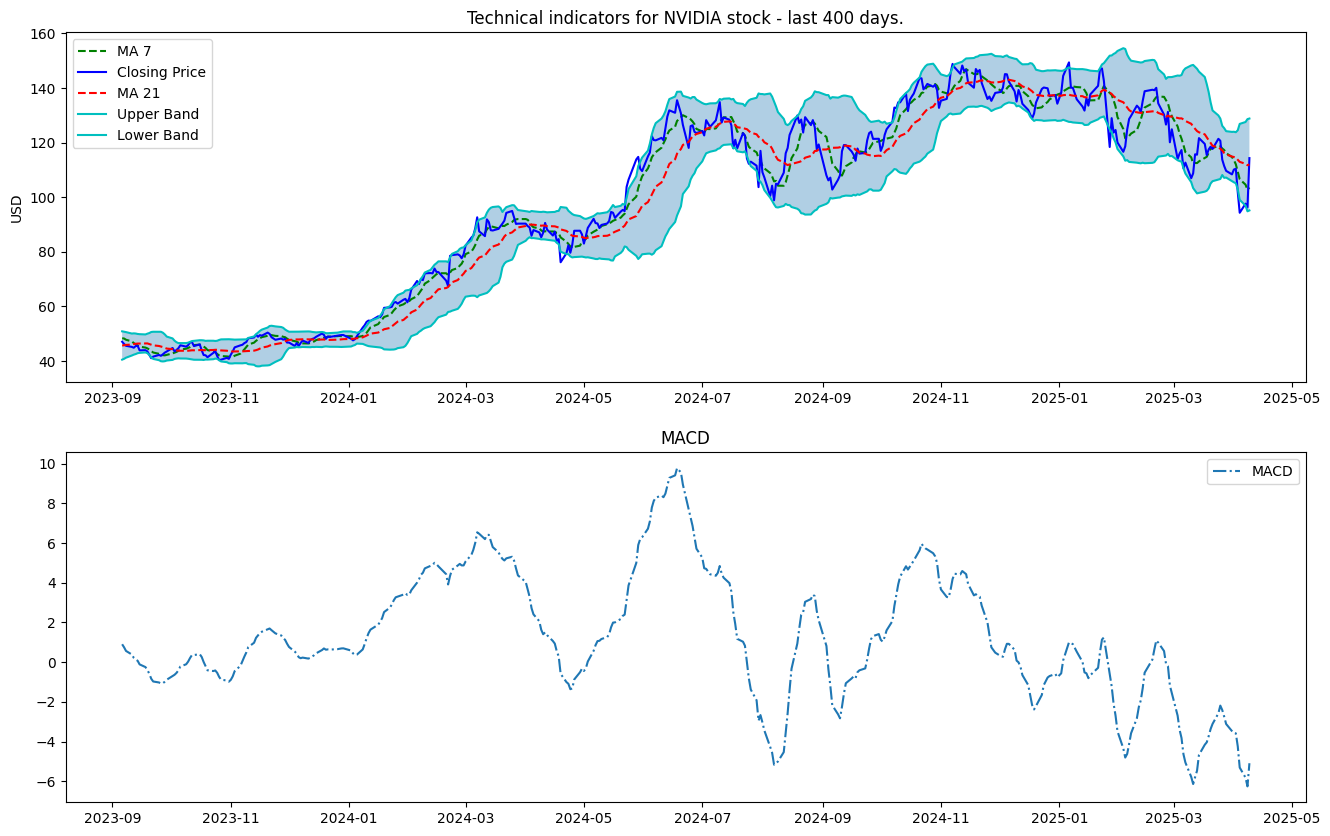

In [102]:
plot_technical_indicators(price_processed, 400)

In [103]:
price_processed.head()

Price,Close,High,Low,Open,Volume,change,change_label,ma7,ma21,26ema,12ema,MACD,20sd,upper_band,lower_band,ema
Ticker,NVDA,NVDA,NVDA,NVDA,NVDA,,,,,,,,,,,
Date,,,,,,,,,,,,,,,,
2023-08-09,42.530781,44.287821,42.111008,44.249840,586449000,-0.003901,False,44.633635,45.400786,45.160389,44.836480,-0.323909,1.183600,47.767986,43.033587,43.290146
2023-08-10,42.364876,43.550230,41.812176,42.137000,492705000,-0.036166,False,44.045528,45.328731,44.906639,44.446346,-0.460294,1.365614,48.059959,42.597502,42.673299
2023-08-11,40.832706,41.995074,40.616825,41.728217,533085000,0.070934,True,43.558079,45.084959,44.542919,43.878217,-0.664702,1.690272,48.465504,41.704415,41.446237
2023-08-14,43.729122,43.776097,40.289003,40.463907,690286000,0.004274,True,43.449280,45.003289,44.471352,43.854856,-0.616496,1.683258,48.369806,41.636772,42.968161
2023-08-15,43.916023,45.243302,43.686149,44.535688,676512000,-0.010332,False,43.343624,44.883307,44.423183,43.864413,-0.558770,1.586142,48.055592,41.711022,43.600069


# Format data for model

In [104]:
#now perhaps convert them to a list, and then tensor, to proceed to process the price data? 

x_input=price_processed.drop(['change','change_label'],axis=1).values

# scaler = MinMaxScaler()
# x_input= scaler.fit_transform(x_input)
x_input=x_input.tolist()

x_label=price_processed['change_label'].values
x_label=x_label.reshape(-1,).tolist()
#try to encode label 
x_label = [1 if x else 0 for x in x_label]


In [105]:
x_input[0]

[42.53078079223633,
 44.28782094053219,
 42.11100798733163,
 44.249839662592294,
 586449000.0,
 44.633634839739116,
 45.40078644525437,
 45.16038919712435,
 44.836480231115004,
 -0.3239089660093484,
 1.183599788992241,
 47.76798602323885,
 43.03358686726989,
 43.29014563821941]

In [106]:
#roe relative price 
# x_input = relative_price.drop(['change','change_label'],axis = 1).values


# # x_input= min_max_scaler.fit_transform(x_input)
# x_input=x_input.tolist()

# x_label=relative_price['change_label'].values
# x_label=x_label.reshape(-1,).tolist()
# #try to encode label 
# x_label = [1 if x else 0 for x in x_label]

In [107]:
x_input[0],x_label[0]

([42.53078079223633,
  44.28782094053219,
  42.11100798733163,
  44.249839662592294,
  586449000.0,
  44.633634839739116,
  45.40078644525437,
  45.16038919712435,
  44.836480231115004,
  -0.3239089660093484,
  1.183599788992241,
  47.76798602323885,
  43.03358686726989,
  43.29014563821941],
 0)

In [108]:
def process(data, window_size):
    output = []
    for i in range(window_size-1, len(data)):
        raw_data = data[i-window_size+1:i+1]
        output.append(raw_data)
    return output

window_size = 10
x_processed = process(x_input, 10)
split = round(len(x_processed)*0.7)
x_train = x_processed[:split]
x_eval = x_processed[split:]
x_train = torch.tensor(x_train, dtype=torch.float)
x_lab = torch.tensor(x_label[window_size-1:window_size-1+split],dtype=torch.float)


x_eval = torch.tensor(x_eval, dtype=torch.float)
x_lab_eval = torch.tensor(x_label[window_size-1+split:],dtype=torch.float)

print(x_train.size())
print(x_lab.size())
print(x_train[0])
print(x_label[0])
print(x_train.type())
print(x_lab.type())
print(x_eval.size())
print(x_lab_eval.size())

torch.Size([287, 10, 14])
torch.Size([287])
tensor([[ 4.2531e+01,  4.4288e+01,  4.2111e+01,  4.4250e+01,  5.8645e+08,
          4.4634e+01,  4.5401e+01,  4.5160e+01,  4.4836e+01, -3.2391e-01,
          1.1836e+00,  4.7768e+01,  4.3034e+01,  4.3290e+01],
        [ 4.2365e+01,  4.3550e+01,  4.1812e+01,  4.2137e+01,  4.9270e+08,
          4.4046e+01,  4.5329e+01,  4.4907e+01,  4.4446e+01, -4.6029e-01,
          1.3656e+00,  4.8060e+01,  4.2598e+01,  4.2673e+01],
        [ 4.0833e+01,  4.1995e+01,  4.0617e+01,  4.1728e+01,  5.3308e+08,
          4.3558e+01,  4.5085e+01,  4.4543e+01,  4.3878e+01, -6.6470e-01,
          1.6903e+00,  4.8466e+01,  4.1704e+01,  4.1446e+01],
        [ 4.3729e+01,  4.3776e+01,  4.0289e+01,  4.0464e+01,  6.9029e+08,
          4.3449e+01,  4.5003e+01,  4.4471e+01,  4.3855e+01, -6.1650e-01,
          1.6833e+00,  4.8370e+01,  4.1637e+01,  4.2968e+01],
        [ 4.3916e+01,  4.5243e+01,  4.3686e+01,  4.4536e+01,  6.7651e+08,
          4.3344e+01,  4.4883e+01,  4.4423

# Prepare the Model

In [109]:
train_data = x_train
train_label = x_lab

eval_data = x_eval
#print(test_data.size())
eval_label = x_lab_eval
#print(test_label)

# batching  data
batch_size = 64
train_data = TensorDataset(train_data, train_label)
train_loader = DataLoader(train_data, batch_size)
train_batches = [batch for batch in train_loader]

eval_data = TensorDataset(eval_data, eval_label)
eval_loader = DataLoader(eval_data, batch_size) 
eval_batches = [batch for batch in eval_loader]

In [110]:
class OurModel(nn.Module):
    def __init__(self, input_size,  hidden_size, num_layers):
        super(OurModel, self).__init__()
        num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(self.input_size, self.hidden_size, num_layers, batch_first=True, bidirectional=False, dropout=0.5)
        self.ff = nn.Linear(self.hidden_size, 1)
        self.dropout = nn.Dropout()

        #need to change the loss function. 
    def forward(self, input):
        output, (hn, cn) = self.lstm(input)
        hn = self.dropout(hn[-1,:,:])
        percent_change = self.ff(hn)
        return percent_change


In [111]:
#define model,

model = OurModel(14, 512, 2)

# for i in range(30):
#     for step, batch in enumerate(train_batches):
#         optimizer.step()
#         model.zero_grad()
        
#         data, label = tuple(t for t in batch)
#         model.train()
#         loss = model(data, label)
#         loss.backward()

#     model.eval()
#     output = evaluation(test_loader, model)
#     print('prediction:', output)
#     print(loss)

In [112]:
#define optimizer, loss function
params = model.parameters()
optimizer = optim.Adam(params)
criterion = nn.BCEWithLogitsLoss()

In [113]:
#Move model to device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
criterion = criterion.to(device)

print (device)

cpu


In [114]:
#check number of parameters. 
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 3,183,105 trainable parameters


In [115]:
def binary_accuracy(preds, y):
    """
    Returns accuracy per batch, i.e. if you get 8/10 right, this returns 0.8, NOT 8
    """

    #round predictions to the closest integer
    rounded_preds = torch.round(torch.sigmoid(preds))
    correct = (rounded_preds == y).float() #convert into float for division 
    acc = correct.sum() / len(correct)
    return acc

In [116]:
#here, let's try to define a function to get the confusion matrix stats



In [117]:
def train(model, train_batches, optimizer, criterion):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.train()

    for step, batch in enumerate(train_batches):
        
        optimizer.zero_grad()
        
        data, label = tuple(t for t in batch)

        data = data.to(device)
        label = label.to(device)

        predictions = model(data).squeeze(1)

        loss = criterion(predictions, label)
        #loss = f1_loss(predictions, label)
        
        acc = binary_accuracy(predictions, label)
        
        loss.backward()
        
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        
    return epoch_loss / len(train_batches), epoch_acc / len(train_batches)

In [118]:
def evaluate(model, eval_batches, criterion):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.eval()
    
    with torch.no_grad():
    
        for step, batch in enumerate(eval_batches):

            data, label = tuple(t for t in batch)
            data = data.to(device)
            label = label.to(device)
            
            predictions = model(data).squeeze(1)
            
            loss = criterion(predictions, label)
            
            acc = binary_accuracy(predictions, label)

            epoch_loss += loss.item()
            epoch_acc += acc.item()
        
    return epoch_loss / len(eval_batches), epoch_acc / len(eval_batches)

In [119]:
import time

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

N_EPOCHS = 10

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):

    start_time = time.time()
    
    train_loss, train_acc = train(model, train_batches, optimizer, criterion)
    valid_loss, valid_acc = evaluate(model, eval_batches, criterion)
    
    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    # if valid_loss < best_valid_loss:
    #     best_valid_loss = valid_loss
    #     torch.save(model.state_dict(), 'tut2-model.pt')
    
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

Epoch: 01 | Epoch Time: 0m 0s
	Train Loss: 0.700 | Train Acc: 53.49%
	 Val. Loss: 0.696 |  Val. Acc: 49.58%
Epoch: 02 | Epoch Time: 0m 0s
	Train Loss: 0.688 | Train Acc: 52.55%
	 Val. Loss: 0.713 |  Val. Acc: 50.42%
Epoch: 03 | Epoch Time: 0m 0s
	Train Loss: 0.689 | Train Acc: 57.55%
	 Val. Loss: 0.710 |  Val. Acc: 50.42%
Epoch: 04 | Epoch Time: 0m 0s
	Train Loss: 0.680 | Train Acc: 57.24%
	 Val. Loss: 0.697 |  Val. Acc: 50.42%
Epoch: 05 | Epoch Time: 0m 0s
	Train Loss: 0.687 | Train Acc: 54.43%
	 Val. Loss: 0.700 |  Val. Acc: 50.42%
Epoch: 06 | Epoch Time: 0m 0s
	Train Loss: 0.689 | Train Acc: 57.86%
	 Val. Loss: 0.708 |  Val. Acc: 50.42%
Epoch: 07 | Epoch Time: 0m 0s
	Train Loss: 0.679 | Train Acc: 57.24%
	 Val. Loss: 0.703 |  Val. Acc: 50.42%
Epoch: 08 | Epoch Time: 0m 0s
	Train Loss: 0.680 | Train Acc: 57.55%
	 Val. Loss: 0.698 |  Val. Acc: 50.42%
Epoch: 09 | Epoch Time: 0m 0s
	Train Loss: 0.686 | Train Acc: 56.28%
	 Val. Loss: 0.701 |  Val. Acc: 50.42%
Epoch: 10 | Epoch Time: 0m 0

In [120]:
len(train_batches)

5

In [121]:
predlist=torch.zeros(0,dtype=torch.long, device='cpu')
lbllist=torch.zeros(0,dtype=torch.long, device='cpu')

with torch.no_grad():
  for step, batch in enumerate(eval_batches):
    data, label = (t for t in batch)
    data = data.to(device)
    label = label.to(device)
    predictions = model(data).squeeze(1)
    predictions = torch.sigmoid(predictions)
    predictions = torch.round(predictions)

    predlist=torch.cat([predlist,predictions.view(-1).cpu()])
    lbllist=torch.cat([lbllist,label.view(-1).cpu()])


In [122]:
conf_mat=confusion_matrix(lbllist.numpy(), predlist.numpy())
print(conf_mat)


[[ 0 61]
 [ 0 62]]


In [123]:
predlist

tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [124]:
lbllist

tensor([1., 0., 1., 1., 1., 1., 0., 0., 1., 1., 0., 1., 0., 0., 1., 1., 1., 1.,
        1., 0., 0., 1., 0., 1., 0., 0., 1., 0., 1., 0., 0., 1., 0., 1., 1., 1.,
        1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 1., 1., 1., 0., 0., 1.,
        0., 1., 1., 1., 0., 0., 0., 0., 0., 1., 0., 1., 1., 1., 1., 0., 0., 1.,
        0., 1., 0., 0., 1., 1., 1., 1., 1., 0., 0., 1., 1., 1., 0., 1., 0., 0.,
        0., 1., 0., 1., 0., 1., 1., 0., 1., 0., 1., 1., 0., 1., 0., 0., 1., 1.,
        0., 1., 0., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 1., 0.])

# Trying out New Loss function for F1

In [125]:
class OurModel2(nn.Module):
    def __init__(self, input_size,  hidden_size, num_layers):
        super(OurModel2, self).__init__()
        num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(self.input_size, self.hidden_size, num_layers, batch_first=True, bidirectional=False, dropout=0.5)
        self.ff = nn.Linear(self.hidden_size, 256)
        self.ff2 = nn.Linear(256,2)
        self.dropout = nn.Dropout()

        #need to change the loss function. 
    def forward(self, input):
        output, (hn, cn) = self.lstm(input)
        hn = self.dropout(hn[-1,:,:])
        percent_change = self.ff(hn)
        percent_change2 = self.ff2(percent_change)
        return percent_change2

model2 = OurModel2(14,512,2)

In [126]:
#define optimizer, loss function
params2 = model2.parameters()
optimizer2 = optim.Adam(params2)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model2 = model2.to(device)

print (device)

cpu


In [127]:
class F1_Loss(nn.Module):
    '''Calculate F1 score. Can work with gpu tensors
    
    The original implmentation is written by Michal Haltuf on Kaggle.
    
    Returns
    -------
    torch.Tensor
        `ndim` == 1. epsilon <= val <= 1
    
    Reference
    ---------
    - https://www.kaggle.com/rejpalcz/best-loss-function-for-f1-score-metric
    - https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html#sklearn.metrics.f1_score
    - https://discuss.pytorch.org/t/calculating-precision-recall-and-f1-score-in-case-of-multi-label-classification/28265/6
    - http://www.ryanzhang.info/python/writing-your-own-loss-function-module-for-pytorch/
    '''
    def __init__(self, epsilon=1e-7):
        super().__init__()
        self.epsilon = epsilon
        
    def forward(self, y_pred, y_true,):
        assert y_pred.ndim == 2
        assert y_true.ndim == 1
        y_true = F.one_hot(y_true, 2).to(torch.float32)
        y_pred = F.softmax(y_pred, dim=1)
        
        tp = (y_true * y_pred).sum(dim=0).to(torch.float32)
        tn = ((1 - y_true) * (1 - y_pred)).sum(dim=0).to(torch.float32)
        fp = ((1 - y_true) * y_pred).sum(dim=0).to(torch.float32)
        fn = (y_true * (1 - y_pred)).sum(dim=0).to(torch.float32)

        precision = tp / (tp + fp + self.epsilon)
        recall = tp / (tp + fn + self.epsilon)

        f1 = 2* (precision*recall) / (precision + recall + self.epsilon)
        f1 = f1.clamp(min=self.epsilon, max=1-self.epsilon)
        return 1 - f1.mean()

f1_loss = F1_Loss().cuda()

In [128]:
def accuracy(preds, y):
    """
    Returns accuracy per batch, i.e. if you get 8/10 right, this returns 0.8, NOT 8
    """

    #round predictions to the closest integer
    prediciton = F.softmax(preds, dim =1)
    _, pred = torch.max(prediciton, 1)
    correct = (pred == y).float() #convert into float for division 
    acc = correct.sum() / len(correct)
    return acc

In [129]:
def train(model, train_batches, optimizer, criterion):
    
    epoch_list=[]
    epoch_loss = 0
    epoch_acc = 0
    
    model.train()

    for step, batch in enumerate(train_batches):
        
        optimizer.zero_grad()
        
        data, label = tuple(t for t in batch)

        data = data.to(device)
        label = label.to(device)

        predictions = model(data)

        loss = f1_loss(predictions, label.to(torch.int64))
        
        acc = accuracy(predictions, label)
        
        loss.backward()
        
        optimizer.step()
        
        epoch_list.append(loss.item())
        epoch_loss += loss.item()
        epoch_acc += acc.item()

    return epoch_loss / len(train_batches), epoch_acc / len(train_batches), epoch_list

In [130]:
def evaluate(model, eval_batches, criterion):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.eval()
    
    with torch.no_grad():
    
        for step, batch in enumerate(eval_batches):

            data, label = tuple(t for t in batch)
            data = data.to(device)
            label = label.to(device)
            
            predictions = model(data)
            
            loss = f1_loss(predictions, label.to(torch.int64))
           
            acc = accuracy(predictions, label)

            epoch_loss += loss.item()
            epoch_acc += acc.item()
        
    return epoch_loss / len(eval_batches), epoch_acc / len(eval_batches)

In [131]:
import time

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

N_EPOCHS = 10

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):

    start_time = time.time()
    
    train_loss, train_acc, train_loss_list = train(model2, train_batches, optimizer2, criterion)
    valid_loss, valid_acc = evaluate(model2, eval_batches, criterion)
    
    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    # if valid_loss < best_valid_loss:
    #     best_valid_loss = valid_loss
    #     torch.save(model.state_dict(), 'tut2-model.pt')
    
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\t Train. Loss: {train_loss:.3f} |  Train. Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

Epoch: 01 | Epoch Time: 0m 0s
	 Train. Loss: 0.505 |  Train. Acc: 48.35%
	 Val. Loss: 0.502 |  Val. Acc: 49.58%
Epoch: 02 | Epoch Time: 0m 0s
	 Train. Loss: 0.511 |  Train. Acc: 50.36%
	 Val. Loss: 0.505 |  Val. Acc: 50.42%
Epoch: 03 | Epoch Time: 0m 0s
	 Train. Loss: 0.497 |  Train. Acc: 57.63%
	 Val. Loss: 0.500 |  Val. Acc: 50.42%
Epoch: 04 | Epoch Time: 0m 0s
	 Train. Loss: 0.495 |  Train. Acc: 60.05%
	 Val. Loss: 0.505 |  Val. Acc: 50.42%
Epoch: 05 | Epoch Time: 0m 0s
	 Train. Loss: 0.498 |  Train. Acc: 54.74%
	 Val. Loss: 0.500 |  Val. Acc: 50.42%
Epoch: 06 | Epoch Time: 0m 0s
	 Train. Loss: 0.511 |  Train. Acc: 50.68%
	 Val. Loss: 0.507 |  Val. Acc: 50.42%
Epoch: 07 | Epoch Time: 0m 0s
	 Train. Loss: 0.499 |  Train. Acc: 53.45%
	 Val. Loss: 0.500 |  Val. Acc: 49.58%
Epoch: 08 | Epoch Time: 0m 0s
	 Train. Loss: 0.512 |  Train. Acc: 48.80%
	 Val. Loss: 0.506 |  Val. Acc: 50.42%
Epoch: 09 | Epoch Time: 0m 0s
	 Train. Loss: 0.508 |  Train. Acc: 51.91%
	 Val. Loss: 0.506 |  Val. Acc:

In [132]:
train_loss_list

[0.4835711717605591,
 0.5045706033706665,
 0.4983976483345032,
 0.5074238181114197,
 0.5101574063301086]

In [133]:
model2.parameters()

<generator object Module.parameters at 0x30942e890>

In [134]:
print (model2)

OurModel2(
  (lstm): LSTM(14, 512, num_layers=2, batch_first=True, dropout=0.5)
  (ff): Linear(in_features=512, out_features=256, bias=True)
  (ff2): Linear(in_features=256, out_features=2, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)


In [135]:
list(model2.parameters())

[Parameter containing:
 tensor([[ 0.0202, -0.0107, -0.0210,  ...,  0.0046,  0.0395,  0.0147],
         [-0.0345, -0.0182, -0.0072,  ...,  0.0012,  0.0439,  0.0373],
         [ 0.0046, -0.0385, -0.0153,  ..., -0.0410, -0.0024, -0.0411],
         ...,
         [-0.0251, -0.0136, -0.0148,  ..., -0.0234,  0.0394, -0.0048],
         [ 0.0340,  0.0056,  0.0125,  ...,  0.0202,  0.0437, -0.0103],
         [ 0.0275, -0.0120, -0.0133,  ..., -0.0041,  0.0411, -0.0041]],
        requires_grad=True),
 Parameter containing:
 tensor([[-0.0287, -0.0172,  0.0282,  ...,  0.0272, -0.0398, -0.0279],
         [ 0.0091, -0.0361, -0.0294,  ..., -0.0140,  0.0028, -0.0326],
         [ 0.0079, -0.0002,  0.0095,  ..., -0.0137,  0.0169,  0.0144],
         ...,
         [-0.0215,  0.0407,  0.0338,  ...,  0.0136, -0.0300,  0.0420],
         [-0.0172, -0.0289, -0.0217,  ..., -0.0055, -0.0273,  0.0365],
         [-0.0424, -0.0195, -0.0410,  ...,  0.0236,  0.0387,  0.0231]],
        requires_grad=True),
 Parameter con

In [136]:
#Check if weights are updated. 

old_state_dict = {}
for key in model2.state_dict():
  old_state_dict[key] = model2.state_dict()[key].clone()

# Your training procedure
import time

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

N_EPOCHS = 10

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):

    start_time = time.time()
    
    train_loss, train_acc, train_loss_list = train(model2, train_batches, optimizer2, criterion)
    valid_loss, valid_acc = evaluate(model2, eval_batches, criterion)
    
    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    # if valid_loss < best_valid_loss:
    #     best_valid_loss = valid_loss
    #     torch.save(model.state_dict(), 'tut2-model.pt')
    
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\t Train. Loss: {train_loss:.3f} |  Train. Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')
# Save new params
new_state_dict = {}
for key in model2.state_dict():
    new_state_dict[key] = model2.state_dict()[key].clone()

# Compare params
for key in old_state_dict:
    if not (old_state_dict[key] == new_state_dict[key]).all():
        print('Diff in {}'.format(key))

Epoch: 01 | Epoch Time: 0m 0s
	 Train. Loss: 0.490 |  Train. Acc: 52.88%
	 Val. Loss: 0.502 |  Val. Acc: 50.42%
Epoch: 02 | Epoch Time: 0m 0s
	 Train. Loss: 0.504 |  Train. Acc: 50.53%
	 Val. Loss: 0.505 |  Val. Acc: 50.42%
Epoch: 03 | Epoch Time: 0m 0s
	 Train. Loss: 0.506 |  Train. Acc: 49.39%
	 Val. Loss: 0.501 |  Val. Acc: 50.42%
Epoch: 04 | Epoch Time: 0m 0s
	 Train. Loss: 0.496 |  Train. Acc: 50.57%
	 Val. Loss: 0.507 |  Val. Acc: 50.42%
Epoch: 05 | Epoch Time: 0m 0s
	 Train. Loss: 0.530 |  Train. Acc: 44.95%
	 Val. Loss: 0.500 |  Val. Acc: 50.42%
Epoch: 06 | Epoch Time: 0m 0s
	 Train. Loss: 0.490 |  Train. Acc: 53.84%
	 Val. Loss: 0.500 |  Val. Acc: 50.42%
Epoch: 07 | Epoch Time: 0m 0s
	 Train. Loss: 0.479 |  Train. Acc: 54.76%
	 Val. Loss: 0.509 |  Val. Acc: 50.42%
Epoch: 08 | Epoch Time: 0m 0s
	 Train. Loss: 0.517 |  Train. Acc: 48.68%
	 Val. Loss: 0.503 |  Val. Acc: 50.42%
Epoch: 09 | Epoch Time: 0m 0s
	 Train. Loss: 0.496 |  Train. Acc: 52.45%
	 Val. Loss: 0.507 |  Val. Acc: